### Inits

In [1]:
import sys
sys.path.append("..")

In [2]:
from balls import *


import mpmath
# import pylab
from pylab import *

#Matplotlib defs
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Numpy
import numpy as np
from numpy.random import multivariate_normal


from scipy import stats
from scipy import stats
import scipy.integrate as integrate
from scipy.interpolate import interp1d as int1d
from scipy.special import erfc as erfc
from scipy.signal import savgol_filter
from scipy.spatial.distance import cdist
from scipy.special import erfcinv as ierfc



import random

import seaborn as sns

from tqdm.notebook import *

import arviz as az

#Astropy
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

#GetDist
from getdist import plots, MCSamples
import getdist

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Data Read

In [4]:
hdul = fits.open('../data/DR7.fits')
data = hdul[1].data  # First extension is the table!
ra = data['RA']
dec = data['DEC']
z = data['REDSHIFT']
mass = data['LOGBH']
dmass = data['LOGBH_ERR']


#define restricted parameters and indicators
m_min=7.9
m_max=13
z_max=2.5
z_min=0.4
ra_min=120
ra_max=240
dec_min=0
dec_max=60
DC_all=cosmo.comoving_distance(z)

# QSO_coord = SkyCoord(ra_new*u.degree, dec_new*u.degree, frame='icrs', distance = DC_new)



# Duty-cycle digitized
lam06=np.loadtxt(open('../../digi/lam06.csv'), delimiter=",")
lam03=np.loadtxt(open('../../digi/lam03.csv'), delimiter=",")
minL=np.loadtxt(open('../../digi/minL.csv'), delimiter=",")
lam03=np.vstack((lam03,[lam03[-1,0]+5,lam03[-1,1]]))
lam06=np.vstack((lam06,[lam06[-1,0]+5,lam06[-1,1]]))
minL=np.vstack((minL,[minL[-1,0]+5,minL[-1,1]]))
intlam06=int1d(lam06[:,0]-0.02,10**lam06[:,1],kind=1)
intlam03=int1d(lam03[:,0]-0.01,10**lam03[:,1],kind=1)
intminL=int1d(minL[:,0],10**minL[:,1],kind=1)

# lamlis=intminL(mass_new)
# lamlis=intlam06(mass_new)

In [5]:
#Make cartsian
def Rvec(r,q,f):
    X=r*np.sin(q)*np.cos(f)
    Y=r*np.sin(q)*np.sin(f)
    Z=r*np.cos(q)
    return np.transpose(np.array([X,Y,Z]))





# QSO_car=Rvec(DC_new.value,dec_new*np.pi/180,ra_new*np.pi/180)
QSO_car=Rvec(DC_all,dec*np.pi/180,ra*np.pi/180)#[(z>z_min) & (z<z_max)]

In [6]:
obs_ball=4079.8773994784547* np.array([[-0.535438571301582, 0, 0.8445741745770591]])#(cosmo.comoving_distance(z_max)-cosmo.comoving_distance(z_min)).value/2*np.array([[-np.sin(60*np.pi/180),0,np.cos(60*np.pi/180)]])
# obs_ball2=(cosmo.comoving_distance(z_max)-cosmo.comoving_distance(z_min)).value/2*np.array([[-np.sin(30*np.pi/180),0,np.cos(30*np.pi/180)]])

In [7]:
z_at_value(cosmo.comoving_distance,4079.8773994784547*u.Mpc),np.arctan2(0.535438571301582,0.8445741745770591)*180/np.pi

(1.299229222239744, 32.3736591270387)

In [8]:
QO_dsit=(cdist(obs_ball,QSO_car).flatten())

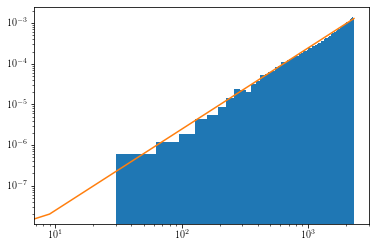

In [9]:
rm=2300
zm=z_at_value(cosmo.comoving_distance,rm*u.Mpc)
zlis=np.linspace(0,zm,300)
xlis=cosmo.comoving_distance(zlis)
ylis=4*np.pi*cosmo.comoving_distance(zlis)**2/cosmo.comoving_volume(zm)

# plt.hist(QO_dsit2[QO_dsit2<rm],bins=50)
plt.hist(QO_dsit[QO_dsit<rm],bins=70,density=1)

plt.plot(xlis,3*xlis**2/rm**3)
plt.yscale('log')
plt.xscale('log')
# plt.plot(xlis,3*ylis2)
plt.show()

In [10]:
QO_dsit.shape

(105783,)

In [12]:
len(QSO_car[QO_dsit<2300]), vol_1(2300)/10**10,(vol_1(2300)/(vol_1(1)*len(QSO_car[QO_dsit<2300])))**(1/3)

(50632, 5.0965010421636014, 62.17075504789603)

In [11]:
m_min=8
m_max=12
z_max=2.5
z_min=0.4

inds=(mass<m_max) & (mass>m_min) & (z < z_max) & (z > z_min) & (QO_dsit<2300)

# restricted arrays
z_new=z[inds]
dec_new=dec[inds]
ra_new=ra[inds]
mass_new=mass[inds]
dmass_new=dmass[inds]
QO_new=QO_dsit[inds]

QSO_car_new=QSO_car[inds]


DC_new=cosmo.comoving_distance(z_new)
DA_new=cosmo.angular_diameter_distance(z_new)

QO_dsit=(cdist(obs_ball,QSO_car_new).flatten())
QQ_dsit=cdist(QSO_car_new,QSO_car_new)

In [ ]:
QO_new[(QO_new>x) & (mass_new>y)])

In [72]:
#Sorted arrays
mass_new_s=np.linspace(np.min(mass_new),np.max(mass_new),20)
QO_new_s=np.logspace(2,np.log10(np.max(QO_new)),50)
n_logm=np.array([[len(QO_new[(QO_new<x) & (mass_new>y)]) for y in (mass_new_s)]/vol_1(x) for x in tqdm(QO_new_s) ])



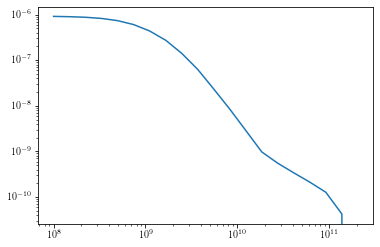

In [83]:
plt.loglog(10**mass_new_s,n_logm[45])
plt.show()

In [106]:
# plt.loglog(10**mass_new,func(10**mass_new, 1, 1, 1, 1),c='black')
0.00682463*mpmath.gammainc(-0.2040816326530,((10**8)**0.49)*0.000149614)
# mpmath.gammainc(1,2)*(np.e)**2
# func(10**mass_new, 0.00682463, -0.204082, 0.49, 0.000149614)

mpf('0.00089152670008246662')

In [130]:
fif=np.array([0.00682463*mpmath.gammainc(-0.904082,0.00024961385482452962*z**0.49) for z in 10**mass_new_s])

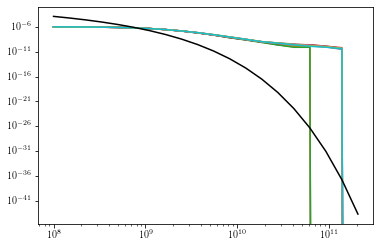

In [131]:
for x in n_logm[-10:]:
    plt.loglog(10**mass_new_s,x)

plt.plot(10**mass_new_s,fif,c='black')
plt.show()



In [134]:
mass_new_s

array([ 8.00020568,  8.17444723,  8.34868879,  8.52293034,  8.6971719 ,
        8.87141345,  9.04565501,  9.21989656,  9.39413812,  9.56837967,
        9.74262123,  9.91686278, 10.09110434, 10.26534589, 10.43958745,
       10.613829  , 10.78807056, 10.96231211, 11.13655367, 11.31079522])

In [111]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(func, 10**mass_new_s,n_logm[45])
popt

array([1., 1., 1., 1.])

In [110]:
def func(x, a, b, c, d):
    tt=10**(-3)*a*np.array([float(mpmath.nstr(mpmath.gammainc(-b,10**(-4)*d*z**c))) for z in x])
    return tt

### Functions and constants

In [48]:
theta_BH_const=(5*const.G*const.M_sun*u.rad/(const.c)**2).to(u.microarcsecond*u.Mpc)
def theta_BH(logM,DA):
    return theta_BH_const*10**logM/DA


# M_sig relation from Ho & Kormendy 2013 in units of km/sec
def MBH_to_sig(logM):
    return (10**(logM-9)/0.31)**(1/4.38)*200

grav_BH_const=(const.G*const.M_sun*u.rad/(u.km/u.s)**2).to(u.arcsecond*u.Mpc)
def grav_BH(logM,DA):
    return grav_BH_const*10**logM/DA/(MBH_to_sig(logM))**2

#Co-moving to Angular Diameter distance
cmd_to_add=int1d(logspace(-2,4.1,200),cosmo.angular_diameter_distance(np.array([z_at_value(cosmo.comoving_distance,x*u.Mpc) for x in logspace(-2,4.1,200)])).value)

In [51]:
lis=np.linspace(0,4,1000)
DA_max=np.max(cosmo.angular_diameter_distance(lis)).value #Mpc
lis=lis[:np.argmax(cosmo.angular_diameter_distance(lis))]
DAt_lis=cosmo.angular_diameter_distance(lis).value
DCt_lis=cosmo.comoving_distance(lis)
DCt_lis=np.append(DCt_lis,cosmo.comoving_distance(lis[-1])).value
DAt_lis=np.append(DAt_lis,DA_max)
add_to_cmd=int1d(DAt_lis,DCt_lis)


In [16]:
## Try
rtest=np.loadtxt('../checks/rtest.csv',delimiter=',')
Dtest=np.loadtxt('../checks/Dtest.csv',delimiter=',')
DDtest=np.loadtxt('../checks/DDtest.csv',delimiter=',')
at,bt=co_vol_23(1,rtest,Dtest,DDtest)
np.sum(bt)/vol_1(1),np.sqrt(2*np.sum(at)/vol_1(1)+np.sum(bt)/vol_1(1)-(np.sum(bt)/vol_1(1))**2)

(3.8617722683127633, 1.5477916719407956)

In [43]:
mass_logs=np.linspace(8,10.5,25)
robs=1300
r1=400
r2=700
r3=1000

volvol=vol_1(robs)
Nmassr1=np.zeros(len(mass_logs))
Smassr1=np.zeros(len(mass_logs))
Nmassr2=np.zeros(len(mass_logs))
Smassr2=np.zeros(len(mass_logs))
Nmassr3=np.zeros(len(mass_logs))
Smassr3=np.zeros(len(mass_logs))
    
for i,x in enumerate(tqdm(mass_logs[:-1])):
    indst=(QO_new<robs+rmax) & (mass_new>x) & (mass_new<mass_logs[i+1])
    QOt=QO_new[indst]
    QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
    
#     a3t,a2t=co_vol_23(robs,0*QOt+r1,QOt,QQt)
#     Nmassr1[i],Smassr1[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)
    
#     a3t,a2t=co_vol_23(robs,0*QOt+r2,QOt,QQt)
#     Nmassr2[i],Smassr2[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)
    
    a3t,a2t=co_vol_23(robs,0*QOt+r3,QOt,QQt)
    Nmassr3[i],Smassr3[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)

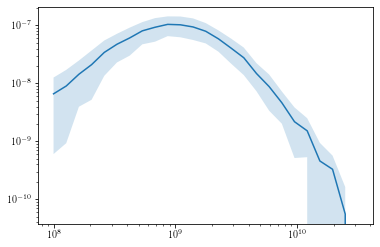

In [45]:
# plt.loglog(10**mass_logs,Nmassr1/vol_1(r1))
# plt.fill_between(10**mass_logs,(Nmassr1+Smassr1)/vol_1(r1),(Nmassr1-Smassr1)/vol_1(r1),alpha=0.2)

# plt.loglog(10**mass_logs,Nmassr2/vol_1(r2))
# plt.fill_between(10**mass_logs,(Nmassr2+Smassr2)/vol_1(r2),(Nmassr2-Smassr2)/vol_1(r2),alpha=0.2)

plt.loglog(10**mass_logs,Nmassr3/vol_1(r3))
plt.fill_between(10**mass_logs,(Nmassr3+Smassr3)/vol_1(r3),(Nmassr3-Smassr3)/vol_1(r3),alpha=0.2)


plt.show()

In [52]:
# Find R_i for a given mass

# Fake D_A*theta[muas] list (i.e. it may be larger than D_A max)
 
def Ri_theta(theta,Rmax,fDA):
    DA_temp=fDA/theta # divide by theta to get the fake DA
    bol_temp=DA_temp>=DA_max # where is it larger than DA_max?
    DA_temp[bol_temp]=np.full(np.sum(bol_temp),DA_max) # replace the ones larger than DA_max by DA_max
    DC_temp=add_to_cmd(DA_temp) # convert DA-->DC
    bol_temp=DC_temp>Rmax # find which ones are larger than Rmax
    DC_temp[bol_temp]=np.full(np.sum(bol_temp),Rmax) # replace the ones larger than R_max by R_max
    return DC_temp

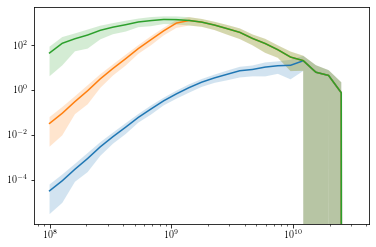

In [96]:
fake_DA_theta=theta_BH(mass_logs,u.Mpc)/u.microarcsecond
vol_m_300=vol_1(Ri_theta(0.01,700,fake_DA_theta))
vol_m_700=vol_1(Ri_theta(0.1,700,fake_DA_theta))
vol_m_1000=vol_1(Ri_theta(1,700,fake_DA_theta))
n3=Nmassr3/vol_1(r3)/(np.diff(mass_logs)[0])
n3p=(Nmassr3+Smassr3)/vol_1(r3)/(np.diff(mass_logs)[0])
n3m=(Nmassr3-Smassr3)/vol_1(r3)/(np.diff(mass_logs)[0])

plt.loglog(10**mass_logs,vol_m_1000*n3)
plt.fill_between(10**mass_logs,vol_m_1000*n3p,vol_m_1000*n3m,alpha=0.2)

plt.loglog(10**mass_logs,vol_m_700*n3)
plt.fill_between(10**mass_logs,vol_m_700*n3p,vol_m_700*n3m,alpha=0.2)

plt.loglog(10**mass_logs,vol_m_300*n3)
plt.fill_between(10**mass_logs,vol_m_300*n3p,vol_m_300*n3m,alpha=0.2)




plt.show()

In [108]:
z_rmax=z_at_value(cosmo.comoving_distance,rmax*u.Mpc)
zran=np.logspace(-4,np.log10(z_rmax),30)
def mmin_z(theta):
    return theta*u.microarcsecond/theta_BH(0,cosmo.angular_diameter_distance(zran))

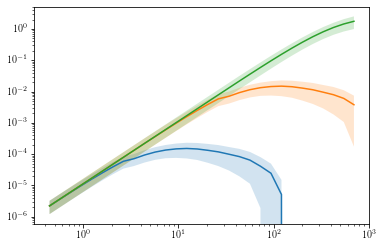

In [109]:
plt.loglog(cosmo.comoving_distance(zran).value,
           np.array([4*np.pi*(cosmo.comoving_distance(zran[i]).value)**2*np.trapz(n3[mass_logs>x],mass_logs[mass_logs>x]) for i,x in enumerate(np.log10(mmin_z(10).value))]))
plt.fill_between(cosmo.comoving_distance(zran).value,
                 np.array([4*np.pi*(cosmo.comoving_distance(zran[i]).value)**2*np.trapz(n3m[mass_logs>x],mass_logs[mass_logs>x]) for i,x in enumerate(np.log10(mmin_z(10).value))]),
                np.array([4*np.pi*(cosmo.comoving_distance(zran[i]).value)**2*np.trapz(n3p[mass_logs>x],mass_logs[mass_logs>x]) for i,x in enumerate(np.log10(mmin_z(10).value))]),alpha=0.2)


plt.loglog(cosmo.comoving_distance(zran).value,
           np.array([4*np.pi*(cosmo.comoving_distance(zran[i]).value)**2*np.trapz(n3[mass_logs>x],mass_logs[mass_logs>x]) for i,x in enumerate(np.log10(mmin_z(1).value))]))
plt.fill_between(cosmo.comoving_distance(zran).value,
                 np.array([4*np.pi*(cosmo.comoving_distance(zran[i]).value)**2*np.trapz(n3m[mass_logs>x],mass_logs[mass_logs>x]) for i,x in enumerate(np.log10(mmin_z(1).value))]),
                np.array([4*np.pi*(cosmo.comoving_distance(zran[i]).value)**2*np.trapz(n3p[mass_logs>x],mass_logs[mass_logs>x]) for i,x in enumerate(np.log10(mmin_z(1).value))]),alpha=0.2)



plt.loglog(cosmo.comoving_distance(zran).value,
           np.array([4*np.pi*(cosmo.comoving_distance(zran[i]).value)**2*np.trapz(n3[mass_logs>x],mass_logs[mass_logs>x]) for i,x in enumerate(np.log10(mmin_z(.1).value))]))
plt.fill_between(cosmo.comoving_distance(zran).value,
                 np.array([4*np.pi*(cosmo.comoving_distance(zran[i]).value)**2*np.trapz(n3m[mass_logs>x],mass_logs[mass_logs>x]) for i,x in enumerate(np.log10(mmin_z(.1).value))]),
                np.array([4*np.pi*(cosmo.comoving_distance(zran[i]).value)**2*np.trapz(n3p[mass_logs>x],mass_logs[mass_logs>x]) for i,x in enumerate(np.log10(mmin_z(.1).value))]),alpha=0.2)


plt.show()


In [18]:
QO_new.shape

(49725,)

In [61]:
theta_logs=np.logspace(-2,2,30)
robs=500
rmax=800
volvol=vol_1(robs)
Ntheta800=np.zeros(len(theta_logs))
Stheta800=np.zeros(len(theta_logs))
Ntheta500=np.zeros(len(theta_logs))
Stheta500=np.zeros(len(theta_logs))
Ntheta300=np.zeros(len(theta_logs))
Stheta300=np.zeros(len(theta_logs))
# for i,x in enumerate(tqdm(theta_logs)):
#     temp=Ri_theta(x,800)
#     a3t,a2t=co_vol_23(robs,temp,QO_dsit,QQ_dsit)
#     Ntheta800[i],Stheta800[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)
    
# for i,x in enumerate(tqdm(theta_logs)):
#     temp=Ri_theta(x,500)
#     a3t,a2t=co_vol_23(robs,temp,QO_dsit,QQ_dsit)
#     Ntheta500[i],Stheta500[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)
    
indst=QO_new<robs+300
QOt=QO_new[indst]
QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
fake_DAt=grav_BH(mass_new[indst],u.Mpc)/u.arcsecond
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,300,fake_DAt)
    a3t,a2t=co_vol_23(robs,temp,QOt,QQt)
    Ntheta300[i],Stheta300[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)

indst=QO_new<robs+500
QOt=QO_new[indst]
QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
fake_DAt=grav_BH(mass_new[indst],u.Mpc)/u.arcsecond
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,500,fake_DAt)
    a3t,a2t=co_vol_23(robs,temp,QOt,QQt)
    Ntheta500[i],Stheta500[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)

indst=QO_new<robs+800
QOt=QO_new[indst]
QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
fake_DAt=grav_BH(mass_new[indst],u.Mpc)/u.arcsecond
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,800,fake_DAt)
    a3t,a2t=co_vol_23(robs,temp,QOt,QQt)
    Ntheta800[i],Stheta800[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)


In [135]:
mass_logs=np.linspace(8,11,30)
robs=1500
rmax=500
volvol=vol_1(robs)

Nmass1=np.zeros(len(mass_logs))
Smass1=np.zeros(len(mass_logs))
Nmassp1=np.zeros(len(mass_logs))
Smassp1=np.zeros(len(mass_logs))
Nmasspp1=np.zeros(len(mass_logs))
Smasspp1=np.zeros(len(mass_logs))
    
for i,x in enumerate(tqdm(mass_logs[:-1])):
    indst=(QO_new<robs+rmax) & (mass_new>x) & (mass_new<mass_logs[i+1])
    QOt=QO_new[indst]
    QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
    fake_DAt=grav_BH(mass_new[indst],u.Mpc)/u.arcsecond
    
    temp=Ri_theta(1,rmax,fake_DAt)
    a3t,a2t=co_vol_23(robs,temp,QOt,QQt)
    Nmass1[i],Smass1[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)
    
    temp=Ri_theta(.1,rmax,fake_DAt)
    a3t,a2t=co_vol_23(robs,temp,QOt,QQt)
    Nmassp1[i],Smassp1[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)
    
    temp=Ri_theta(.01,rmax,fake_DAt)
    a3t,a2t=co_vol_23(robs,temp,QOt,QQt)
    Nmasspp1[i],Smasspp1[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)


In [129]:
np.diff(mass_logs)[0]

0.1034482758620694

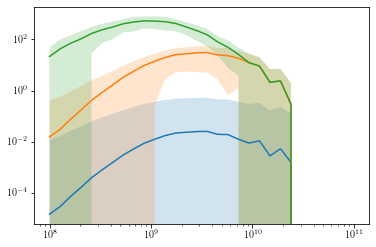

In [136]:
plt.loglog(10**mass_logs,Nmass1/np.diff(mass_logs)[0])
plt.fill_between(10**mass_logs,(Nmass1+Smass1)/np.diff(mass_logs)[0],(Nmass1-Smass1)/np.diff(mass_logs)[0],alpha=.2)
plt.loglog(10**mass_logs,Nmassp1/np.diff(mass_logs)[0])
plt.fill_between(10**mass_logs,(Nmassp1+Smassp1)/np.diff(mass_logs)[0],(Nmassp1-Smassp1)/np.diff(mass_logs)[0],alpha=.2)
plt.loglog(10**mass_logs,Nmasspp1/np.diff(mass_logs)[0])
plt.fill_between(10**mass_logs,(Nmasspp1+Smasspp1)/np.diff(mass_logs)[0],(Nmasspp1-Smasspp1)/np.diff(mass_logs)[0],alpha=.2)
plt.show()

In [170]:
np.sum((QO_new<dist_logs[11]) & (mass_new>mass_logs[2]) & (mass_new<mass_logs[3]))

13

In [209]:
mass_logs=np.linspace(8,11,20)
dist_logs=np.logspace(2,np.log10(2300),10)
arr=np.zeros((len(mass_logs)-1,len(dist_logs)))
for i,x in enumerate(tqdm(mass_logs[:-1])):
    for j,y in enumerate(dist_logs):
        arr[i,j]=np.sum((QO_new<y) & (mass_new>x) & (mass_new<mass_logs[i+1]))/vol_1(y)

    

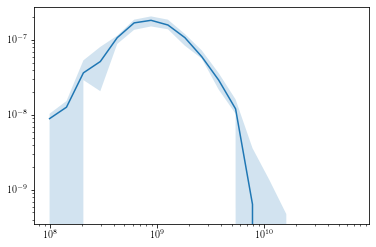

In [210]:
plt.loglog(10**mass_logs[:-1],np.array([np.median(x) for x in arr]))
plt.fill_between(10**mass_logs[:-1],*np.transpose(np.array([az.hdi(x,.68) for x in arr])),alpha=0.2)
plt.show()

In [ ]:
for x in tqdm(np.logspace(2.5,np.log10(2300),10)):
    plt.hist(mass_new[QO_new<x],bins=50,histtype='step',density=1)
plt.yscale('log')
plt.show()

In [22]:
def prec(q,mu,si):
    X=(si/mu)**2
    Y=np.sqrt(2)*ierfc(2*q)
    Z=np.log(1+X)
    W=mu/np.sqrt(1+X)
    return W*np.exp(-Y*Z)
prec(.1,Ntheta300,Stheta300)

array([1.04549452e+02, 1.04475006e+02, 1.03818647e+02, 1.00985736e+02,
       9.35803697e+01, 7.48547885e+01, 4.63713280e+01, 2.28026772e+01,
       9.02892626e+00, 2.72326877e+00, 6.03164542e-01, 9.16168082e-02,
       9.25342606e-03, 7.47618083e-04, 5.54243860e-05, 3.95917833e-06,
       2.83244588e-07, 2.00749974e-08, 1.41631140e-09, 1.00082108e-10,
       7.09250898e-12, 5.03631128e-13, 3.58638517e-14, 2.54686943e-15,
       1.80517687e-16, 1.27930207e-17, 9.05457615e-19, 6.39613680e-20,
       4.51784045e-21, 3.19112660e-22])

In [43]:
lis=(2*np.random.rand(3*10**5,3)-1)*400
def norm_vec(arr):
    return np.sqrt(np.sum(arr**2,axis=1))
randp=lis[norm_vec(lis)<400][:8*10**4]+obs_ball

# dists=np.array([norm_vec(x-QSO_car_new) for x in tqdm(randp)])

In [69]:
fake_DAt=grav_BH(mass_new[QO_new<700],u.Mpc)/u.arcsecond
QSOt=QSO_car_new[QO_new<700]
dists=np.array([norm_vec(x-QSOt) for x in tqdm(randp)])

In [60]:
1-10**(-3)

0.999

In [79]:
cllis[1].shape

(2,)

In [92]:
medlis=np.zeros(len(theta_logs))
mnlis=np.zeros(len(theta_logs))
sdlis=np.zeros(len(theta_logs))
cllis=np.zeros((len(theta_logs),2))
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,300,fake_DAt)
    tarr=np.array([np.sum((y-temp<0)) for y in tqdm(dists,leave=False)])
    cllis[i]=az.hdi(tarr,.68)
    medlis[i]=np.median(tarr)
    mnlis[i]=np.mean(tarr)
    sdlis[i]=np.std(tarr)



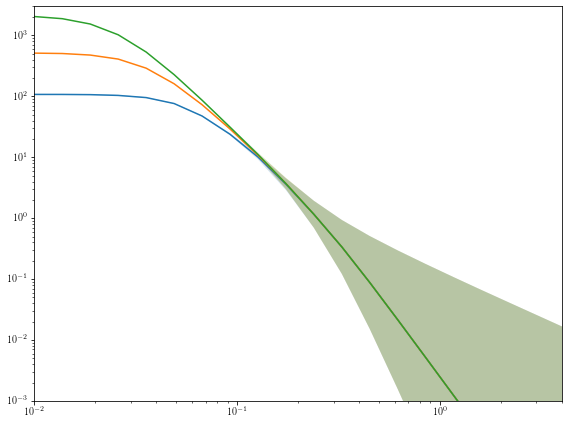

In [27]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
ax.loglog(theta_logs,prec(.5,Ntheta300,Stheta300))
ax.fill_between(theta_logs,prec(.5-.341,Ntheta300,Stheta300),prec(.5+.341,Ntheta300,Stheta300),alpha=.2)

ax.loglog(theta_logs,prec(.5,Ntheta500,Stheta500))
ax.fill_between(theta_logs,prec(.5-.341,Ntheta500,Stheta500),prec(.5+.341,Ntheta500,Stheta500),alpha=.2)

ax.loglog(theta_logs,prec(.5,Ntheta800,Stheta800))
ax.fill_between(theta_logs,prec(.5-.341,Ntheta800,Stheta800),prec(.5+.341,Ntheta800,Stheta800),alpha=.2)


plt.xlim(.01,4)
plt.ylim(.001,3*10**3)
plt.show()

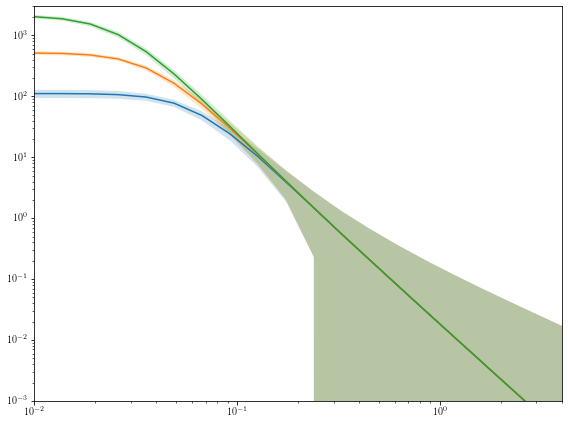

In [95]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
ax.loglog(theta_logs,Ntheta300)
ax.fill_between(theta_logs,Ntheta300+Stheta300,Ntheta300-Stheta300,alpha=.2)
ax.loglog(theta_logs,Ntheta500)
ax.fill_between(theta_logs,Ntheta500+Stheta500,Ntheta500-Stheta500,alpha=.2)

ax.loglog(theta_logs,Ntheta800)
ax.fill_between(theta_logs,Ntheta800+Stheta800,Ntheta800-Stheta800,alpha=.2)

# ax.loglog(theta_logs,medlis)
# ax,fill_between(theta_logs,*np.transpose(cllis),alpha=0.2)

# ax.loglog(theta_logs,mnlis,ls='--')
# ax.fill_between(theta_logs,mnlis+sdlis,mnlis-sdlis,alpha=.2)

plt.xlim(.01,4)
plt.ylim(.001,3*10**3)
plt.show()

In [278]:
QO_dsit=(cdist(obs_ball,QSO_car).flatten())

In [32]:
volvol=vol_1(robs)
N_rmax=np.zeros(len(theta_logs))
S_rmax=np.zeros(len(theta_logs))
N_temp=np.zeros(len(dist_lis))
S_temp=np.zeros(len(dist_lis))
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,100)
    for j,y in enumerate(tqdm(dist_lis,leave=False)):
        temp3,temp2=co_vol_23(robs,temp,y,QQ_dsit)
        N_temp[j]=np.sum(temp2)
        S_temp[j]=np.sum(temp3)
    N_rmax[i],S_rmax[i]=np.mean(N_temp)/volvol,np.sqrt(2*np.mean(S_temp)/volvol+np.mean(N_temp)/volvol-(np.mean(N_temp)/volvol)**2)
    temp=Ri_theta(x,500)
    for j,y in enumerate(tqdm(dist_lis,leave=False)):
        temp3,temp2=co_vol_23(robs,temp,y,QQ_dsit)
        N_temp[j]=np.sum(temp2)
        S_temp[j]=np.sum(temp3)
    N_rmax[i],S_rmax[i]=np.mean(N_temp)/volvol,np.sqrt(2*np.mean(S_temp)/volvol+np.mean(N_temp)/volvol-(np.mean(N_temp)/volvol)**2)
    temp=Ri_theta(x,800)
    for j,y in enumerate(tqdm(dist_lis,leave=False)):
        temp3,temp2=co_vol_23(robs,temp,y,QQ_dsit)
        N_temp[j]=np.sum(temp2)
        S_temp[j]=np.sum(temp3)
    N_rmax[i],S_rmax[i]=np.mean(N_temp)/volvol,np.sqrt(2*np.mean(S_temp)/volvol+np.mean(N_temp)/volvol-(np.mean(N_temp)/volvol)**2)
    

KeyboardInterrupt: 

In [13]:
OBS_ball_pos=np.loadtxt('../data/ball_200_800_pos.csv',delimiter=',')
rmax=800#10**np.loadtxt('../../digi/ball_range_pos.csv',delimiter=',')[28]
robs=200
dist_lis=cdist(OBS_ball_pos,QSO_car)
rmax

800

In [191]:
theta_logs=np.logspace(-2,2,30)


arr_theta_700=np.zeros((len(theta_logs),len(dist_lis)))
arr_theta_500=np.zeros((len(theta_logs),len(dist_lis)))
arr_theta_300=np.zeros((len(theta_logs),len(dist_lis)))
volt=vol_1(robs)
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,rmax)
    arr_theta_700[i]=np.array([np.sum(co_vol_2(robs,temp,j)[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(x,500)
    arr_theta_500[i]=np.array([np.sum(co_vol_2(robs,temp,j)[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(x,100)
    arr_theta_300[i]=np.array([np.sum(co_vol_2(robs,temp,j)[0]) for j in (dist_lis)])/volt



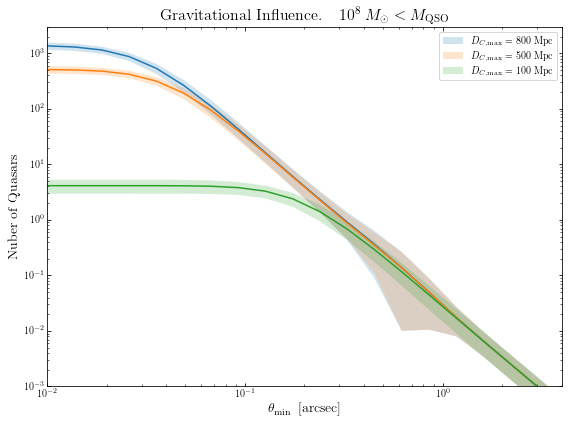

In [192]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(theta_logs,np.mean(arr_theta_700,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_700,axis=1)+np.std(arr_theta_700,axis=1),np.mean(arr_theta_700,axis=1)-np.std(arr_theta_700,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=800\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_500,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_500,axis=1)+np.std(arr_theta_500,axis=1),np.mean(arr_theta_500,axis=1)-np.std(arr_theta_500,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=500\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_300,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_300,axis=1)+np.std(arr_theta_300,axis=1),np.mean(arr_theta_300,axis=1)-np.std(arr_theta_300,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=100\;\rm{Mpc}$')

plt.xlim(.01,4)
plt.ylim(.001,3*10**3)

plt.ylabel(r'$\rm{Nuber\;of\;Quasars}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;\left[{\rm arcsec}\right]$', fontsize=14)

plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)


ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

ax.legend(loc='upper right',fontsize=10) 

plt.savefig('../figs/grav_tot_all.pdf')

plt.show()

In [18]:
theta_logs=np.logspace(-2,2,30)

mass_inds=mass_new<10.5

dist_lis_less=dist_lis
arr_theta_700=np.zeros((len(theta_logs),len(dist_lis)))
arr_theta_500=np.zeros((len(theta_logs),len(dist_lis)))
arr_theta_300=np.zeros((len(theta_logs),len(dist_lis)))
volt=vol_1(robs)
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,rmax)[mass_inds]
    arr_theta_700[i]=np.array([np.sum(co_vol_2(robs,temp,j[mass_inds])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(x,500)[mass_inds]
    arr_theta_500[i]=np.array([np.sum(co_vol_2(robs,temp,j[mass_inds])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(x,100)[mass_inds]
    arr_theta_300[i]=np.array([np.sum(co_vol_2(robs,temp,j[mass_inds])[0]) for j in (dist_lis)])/volt



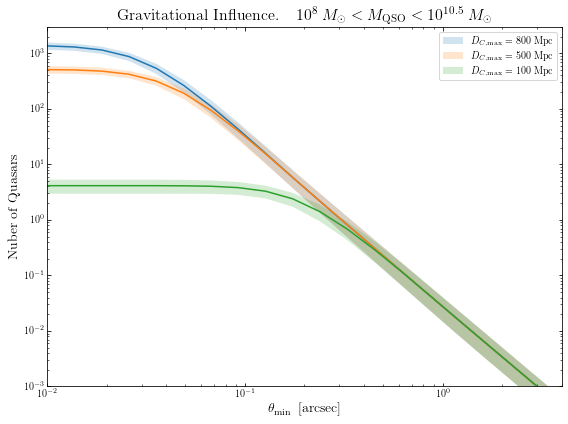

In [194]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(theta_logs,np.mean(arr_theta_700,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_700,axis=1)+np.std(arr_theta_700,axis=1),np.mean(arr_theta_700,axis=1)-np.std(arr_theta_700,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=800\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_500,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_500,axis=1)+np.std(arr_theta_500,axis=1),np.mean(arr_theta_500,axis=1)-np.std(arr_theta_500,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=500\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_300,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_300,axis=1)+np.std(arr_theta_300,axis=1),np.mean(arr_theta_300,axis=1)-np.std(arr_theta_300,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=100\;\rm{Mpc}$')

plt.xlim(.01,4)
plt.ylim(.001,3*10**3)

plt.ylabel(r'$\rm{Nuber\;of\;Quasars}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;\left[{\rm arcsec}\right]$', fontsize=14)

plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}<10^{10.5}\;M_\odot$', fontsize=16)




ax.legend(loc='upper right',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/grav_tot_limited.pdf')


plt.show()

In [32]:
volvol=vol_1(robs)
N_rmax=np.zeros(len(theta_logs))
S_rmax=np.zeros(len(theta_logs))
N_temp=np.zeros(len(dist_lis))
S_temp=np.zeros(len(dist_lis))
for i,x in enumerate(tqdm(theta_logs)):
    temp=Ri_theta(x,100)
    for j,y in enumerate(tqdm(dist_lis,leave=False)):
        temp3,temp2=co_vol_23(robs,temp,y,QQ_dsit)
        N_temp[j]=np.sum(temp2)
        S_temp[j]=np.sum(temp3)
    N_rmax[i],S_rmax[i]=np.mean(N_temp)/volvol,np.sqrt(2*np.mean(S_temp)/volvol+np.mean(N_temp)/volvol-(np.mean(N_temp)/volvol)**2)
    temp=Ri_theta(x,500)
    for j,y in enumerate(tqdm(dist_lis,leave=False)):
        temp3,temp2=co_vol_23(robs,temp,y,QQ_dsit)
        N_temp[j]=np.sum(temp2)
        S_temp[j]=np.sum(temp3)
    N_rmax[i],S_rmax[i]=np.mean(N_temp)/volvol,np.sqrt(2*np.mean(S_temp)/volvol+np.mean(N_temp)/volvol-(np.mean(N_temp)/volvol)**2)
    temp=Ri_theta(x,800)
    for j,y in enumerate(tqdm(dist_lis,leave=False)):
        temp3,temp2=co_vol_23(robs,temp,y,QQ_dsit)
        N_temp[j]=np.sum(temp2)
        S_temp[j]=np.sum(temp3)
    N_rmax[i],S_rmax[i]=np.mean(N_temp)/volvol,np.sqrt(2*np.mean(S_temp)/volvol+np.mean(N_temp)/volvol-(np.mean(N_temp)/volvol)**2)
    

KeyboardInterrupt: 

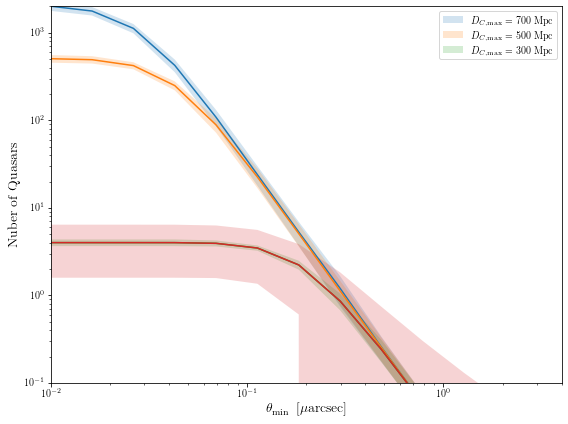

In [31]:
ig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(theta_logs,np.mean(arr_theta_700,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_700,axis=1)+np.std(arr_theta_700,axis=1),np.mean(arr_theta_700,axis=1)-np.std(arr_theta_700,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=700\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_500,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_500,axis=1)+np.std(arr_theta_500,axis=1),np.mean(arr_theta_500,axis=1)-np.std(arr_theta_500,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=500\;\rm{Mpc}$')

ax.loglog(theta_logs,np.mean(arr_theta_300,axis=1))
ax.fill_between(theta_logs,np.mean(arr_theta_300,axis=1)+np.std(arr_theta_300,axis=1),np.mean(arr_theta_300,axis=1)-np.std(arr_theta_300,axis=1), alpha=0.2,
                label=r'$D_{C,\rm{max}}=300\;\rm{Mpc}$')

ax.loglog(theta_logs,N_rmax)
ax.fill_between(theta_logs,N_rmax+S_rmax,N_rmax-S_rmax,alpha=0.2)

plt.xlim(.01,4)
plt.ylim(.1,2*10**3)

plt.ylabel(r'$\rm{Nuber\;of\;Quasars}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;\left[\mu{\rm arcsec}\right]$', fontsize=14)

ax.legend(loc='upper right',fontsize=10) 

plt.show()

# Distance

In [15]:
OBS_ball_pos=np.loadtxt('../data/ball_200_1000_pos.csv',delimiter=',')
rmax=1000
dist_logs=np.logspace(0,np.log10(rmax),25)
robs=200


volt=vol_1(robs)
arr_dist_p01=np.zeros((len(dist_logs),len(dist_lis)))
arr_dist_p1=np.zeros((len(dist_logs),len(dist_lis)))
arr_dist_1=np.zeros((len(dist_logs),len(dist_lis)))
for i,x in enumerate(tqdm(dist_logs)):
    tempp1=Ri_theta(.1,x)
    temp1=Ri_theta(1,x)
    tempp01=Ri_theta(.01,x)
    arr_dist_p1[i]=np.array([np.sum(co_vol_2(robs,tempp1,j)[0]) for j in (dist_lis)])/volt
    arr_dist_1[i]=np.array([np.sum(co_vol_2(robs,temp1,j)[0]) for j in (dist_lis)])/volt
    arr_dist_p01[i]=np.array([np.sum(co_vol_2(robs,tempp01,j)[0]) for j in (dist_lis)])/volt
    

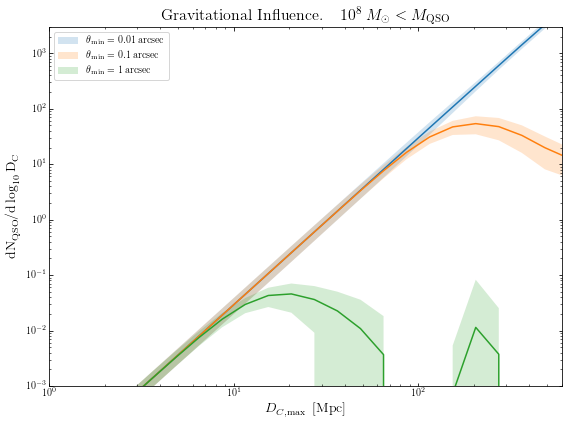

In [16]:
dd=np.diff(np.log10(dist_logs))[0]
dist_logs_diff=np.sqrt(dist_logs[1:]*dist_logs[:-1])
arr_diff_dist_p1=np.diff(arr_dist_p1,axis=0)/dd
arr_diff_dist_1=np.diff(arr_dist_1,axis=0)/dd
arr_diff_dist_p01=np.diff(arr_dist_p01,axis=0)/dd

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_p01,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_p01,axis=1)+np.std(arr_diff_dist_p01,axis=1),np.mean(arr_diff_dist_p01,axis=1)-np.std(arr_diff_dist_p01,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.01\;{\rm arcsec}$')

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_p1,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_p1,axis=1)+np.std(arr_diff_dist_p1,axis=1),np.mean(arr_diff_dist_p1,axis=1)-np.std(arr_diff_dist_p1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;{\rm arcsec}$')

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_1,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_1,axis=1)+np.std(arr_diff_dist_1,axis=1),np.mean(arr_diff_dist_1,axis=1)-np.std(arr_diff_dist_1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;{\rm arcsec}$')



plt.xlim(1,600)
plt.ylim(10**(-3),3*10**3)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}D_C}$', fontsize=14)
plt.xlabel(r'$D_{C,\rm{max}}\;\left[\rm{Mpc}\right]$', fontsize=14)
plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)

ax.legend(loc='upper left',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/grav_dNdD_all.pdf')


plt.show()

In [19]:
OBS_ball_pos=np.loadtxt('../data/ball_200_1000_pos.csv',delimiter=',')
rmax=1000
dist_logs=np.logspace(0,np.log10(rmax),25)
robs=200


volt=vol_1(robs)
arr_dist_p01=np.zeros((len(dist_logs),len(dist_lis)))
arr_dist_p1=np.zeros((len(dist_logs),len(dist_lis)))
arr_dist_1=np.zeros((len(dist_logs),len(dist_lis)))
for i,x in enumerate(tqdm(dist_logs)):
    tempp1=Ri_theta(.1,x)[mass_inds]
    temp1=Ri_theta(1,x)[mass_inds]
    tempp01=Ri_theta(.01,x)[mass_inds]
    arr_dist_p1[i]=np.array([np.sum(co_vol_2(robs,tempp1,j[mass_inds])[0]) for j in (dist_lis)])/volt
    arr_dist_1[i]=np.array([np.sum(co_vol_2(robs,temp1,j[mass_inds])[0]) for j in (dist_lis)])/volt
    arr_dist_p01[i]=np.array([np.sum(co_vol_2(robs,tempp01,j[mass_inds])[0]) for j in (dist_lis)])/volt
    

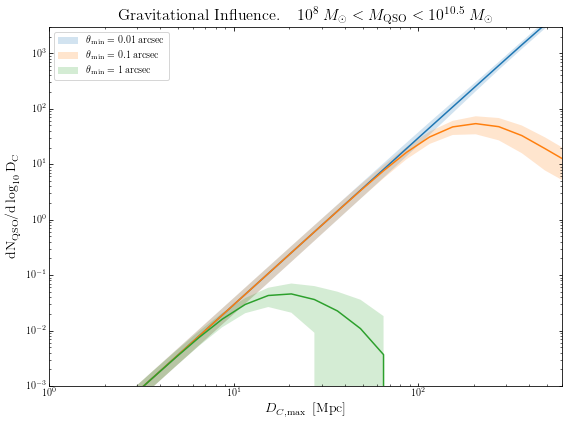

In [20]:
dd=np.diff(np.log10(dist_logs))[0]
dist_logs_diff=np.sqrt(dist_logs[1:]*dist_logs[:-1])
arr_diff_dist_p1=np.diff(arr_dist_p1,axis=0)/dd
arr_diff_dist_1=np.diff(arr_dist_1,axis=0)/dd
arr_diff_dist_p01=np.diff(arr_dist_p01,axis=0)/dd

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_p01,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_p01,axis=1)+np.std(arr_diff_dist_p01,axis=1),np.mean(arr_diff_dist_p01,axis=1)-np.std(arr_diff_dist_p01,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.01\;{\rm arcsec}$')

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_p1,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_p1,axis=1)+np.std(arr_diff_dist_p1,axis=1),np.mean(arr_diff_dist_p1,axis=1)-np.std(arr_diff_dist_p1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;{\rm arcsec}$')

ax.loglog(dist_logs_diff,np.mean(arr_diff_dist_1,axis=1))
ax.fill_between(dist_logs_diff,np.mean(arr_diff_dist_1,axis=1)+np.std(arr_diff_dist_1,axis=1),np.mean(arr_diff_dist_1,axis=1)-np.std(arr_diff_dist_1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;{\rm arcsec}$')



plt.xlim(1,600)
plt.ylim(10**(-3),3*10**3)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}D_C}$', fontsize=14)
plt.xlabel(r'$D_{C,\rm{max}}\;\left[\rm{Mpc}\right]$', fontsize=14)
plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}<10^{10.5}\;M_\odot$', fontsize=16)

ax.legend(loc='upper left',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/grav_dNdD_limited.pdf')


plt.show()

# Mass function

In [189]:
mass_bins=np.linspace(np.min(mass_new),np.max(mass_new),25)
OBS_ball_pos=np.loadtxt('../data/ball_200_700_pos.csv',delimiter=',')
rmax=700
robs=200
volt=vol_1(robs)


arr_mass_1=np.zeros((len(mass_bins),len(dist_lis)))
arr_mass_p1=np.zeros((len(mass_bins),len(dist_lis)))
arr_mass_pp1=np.zeros((len(mass_bins),len(dist_lis)))


for i,x in enumerate(tqdm(mass_bins[1:])):
    tind=(mass_new>mass_bins[i]) & (mass_new<x)
    temp=Ri_theta(1,rmax)[tind]
    arr_mass_1[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(.1,rmax)[tind]
    arr_mass_p1[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(.01,rmax)[tind]
    arr_mass_pp1[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt

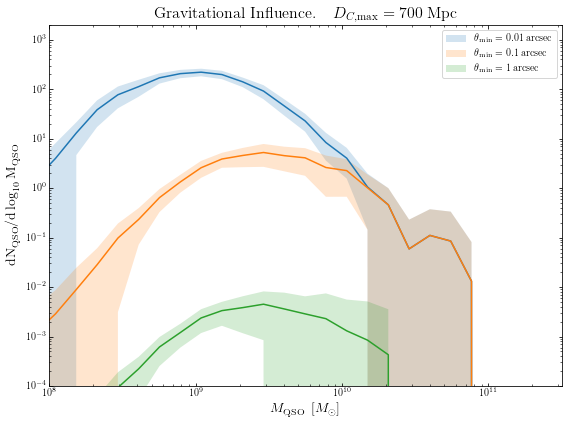

In [190]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(10**mass_bins,np.mean(arr_mass_pp1,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_pp1,axis=1)+np.std(arr_mass_pp1,axis=1),np.mean(arr_mass_pp1,axis=1)-np.std(arr_mass_pp1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.01\;\rm{arcsec}$')

ax.loglog(10**mass_bins,np.mean(arr_mass_p1,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_p1,axis=1)+np.std(arr_mass_p1,axis=1),np.mean(arr_mass_p1,axis=1)-np.std(arr_mass_p1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;\rm{arcsec}$')

ax.loglog(10**mass_bins,np.mean(arr_mass_1,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_1,axis=1)+np.std(arr_mass_1,axis=1),np.mean(arr_mass_1,axis=1)-np.std(arr_mass_1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;\rm{arcsec}$')


plt.xlim(10**8,10**11.5)
plt.ylim(10**(-4),2*10**3)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}M_{\rm QSO}}$', fontsize=14)
plt.xlabel(r'$M_{\rm QSO}\;\left[M_\odot\right]$', fontsize=14)

plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;D_{C,\rm{max}}=700\;\rm Mpc$', fontsize=16)

ax.legend(loc='upper right',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/grav_dNdM_all.pdf')

plt.show()

In [173]:
mass_bins[1:-6]

array([ 8.04233873,  8.18444554,  8.32655234,  8.46865914,  8.61076595,
        8.75287275,  8.89497956,  9.03708636,  9.17919316,  9.32129997,
        9.46340677,  9.60551358,  9.74762038,  9.88972718, 10.03183399,
       10.17394079, 10.3160476 , 10.4581544 ])

In [187]:
OBS_ball_pos=np.loadtxt('../data/ball_200_700_pos.csv',delimiter=',')
rmax=700
robs=200
volt=vol_1(robs)

arr_mass_1=np.zeros((len(mass_bins),len(dist_lis)))
arr_mass_p1=np.zeros((len(mass_bins),len(dist_lis)))
arr_mass_pp1=np.zeros((len(mass_bins),len(dist_lis)))


for i,x in enumerate(tqdm(mass_bins[1:-6])):
    tind=(mass_new>mass_bins[i]) & (mass_new<x)
    temp=Ri_theta(1,rmax)[tind]
    arr_mass_1[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(.1,rmax)[tind]
    arr_mass_p1[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt
    temp=Ri_theta(.01,rmax)[tind]
    arr_mass_pp1[i]=np.array([np.sum(co_vol_2(robs,temp,j[tind])[0]) for j in (dist_lis)])/volt

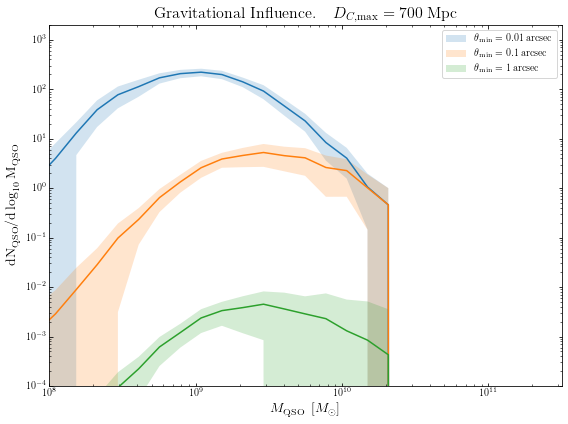

In [188]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(10**mass_bins,np.mean(arr_mass_pp1,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_pp1,axis=1)+np.std(arr_mass_pp1,axis=1),np.mean(arr_mass_pp1,axis=1)-np.std(arr_mass_pp1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.01\;\rm{arcsec}$')

ax.loglog(10**mass_bins,np.mean(arr_mass_p1,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_p1,axis=1)+np.std(arr_mass_p1,axis=1),np.mean(arr_mass_p1,axis=1)-np.std(arr_mass_p1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;\rm{arcsec}$')

ax.loglog(10**mass_bins,np.mean(arr_mass_1,axis=1))
ax.fill_between(10**mass_bins,np.mean(arr_mass_1,axis=1)+np.std(arr_mass_1,axis=1),np.mean(arr_mass_1,axis=1)-np.std(arr_mass_1,axis=1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;\rm{arcsec}$')


plt.xlim(10**8,10**11.5)
plt.ylim(10**(-4),2*10**3)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}M_{\rm QSO}}$', fontsize=14)
plt.xlabel(r'$M_{\rm QSO}\;\left[M_\odot\right]$', fontsize=14)

plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;D_{C,\rm{max}}=700\;\rm Mpc$', fontsize=16)

ax.legend(loc='upper right',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/grav_dNdM_limited.pdf')

plt.show()

In [186]:
for i,x in enumerate(tqdm(mass_bins[1:-6])):
    print(mass_bins[i],x)

7.9002319286690845 8.042338732650737
8.042338732650737 8.184445536632392
8.184445536632392 8.326552340614045
8.326552340614045 8.468659144595698
8.468659144595698 8.610765948577352
8.610765948577352 8.752872752559005
8.752872752559005 8.894979556540658
8.894979556540658 9.037086360522313
9.037086360522313 9.179193164503966
9.179193164503966 9.321299968485619
9.321299968485619 9.463406772467273
9.463406772467273 9.605513576448926
9.605513576448926 9.747620380430579
9.747620380430579 9.889727184412234
9.889727184412234 10.031833988393887
10.031833988393887 10.17394079237554
10.17394079237554 10.316047596357194
10.316047596357194 10.458154400338847



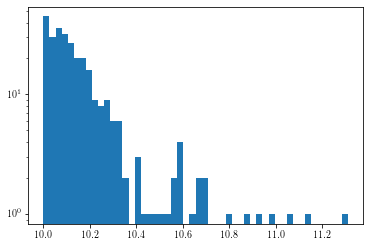

In [45]:
plt.hist(mass_new[mass_new>10],bins=50)
plt.yscale('log')
plt.show()